# Fetch and Store Historical Bitcoin Data in PostgreSQL

This notebook demonstrates how to fetch historical Bitcoin (BTC) data from the CryptoCompare API, process the data, and store it in a PostgreSQL database. The process is broken down into the following steps:

## Steps:
1. **Load Environment Variables**: We load API keys and database URL from an `.env` file.
2. **Configure Database Connection**: We set up a connection to the PostgreSQL database using SQLAlchemy.
3. **API Interaction**: We fetch historical data for Bitcoin in chunks, using the CryptoCompare API.
4. **Data Processing**: The data is processed, including renaming columns, converting timestamps, and handling duplicates.
5. **Store in Database**: The processed data is stored in a PostgreSQL database table.

### Required Libraries:
- `os`: For handling environment variables.
- `time`: For managing time intervals.
- `pandas`: For data manipulation and storage.
- `requests`: For making HTTP requests to the CryptoCompare API.
- `dotenv`: For loading environment variables from the `.env` file.
- `sqlalchemy`: For connecting to the PostgreSQL database.


In [3]:
! pip install python-dotenv requests pandas sqlalchemy psycopg2-binary statsmodels matplotlib


  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached sqlalchemy-2.0.40-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
  Using cached statsmodels-0.14.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 13.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 15.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.0/606.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import time

import pandas as pd
import requests
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [3]:
# Load Env variables
load_dotenv()  
API_KEY      = os.getenv("API_KEY")
DATABASE_URL = os.getenv("DATABASE_URL")


if not API_KEY:
    raise EnvironmentError("API_KEY missing.")
if not DATABASE_URL:
    raise EnvironmentError("DATABASE_URL missing.")


### PATCH DATABASE URL FOR SQLALCHEMY ≥1.4

In [4]:
# SQLAlchemy 1.4+ rejects "postgres://"; it needs "postgresql://"
if DATABASE_URL.startswith("postgres://"):
    DATABASE_URL = DATABASE_URL.replace("postgres://", "postgresql://", 1)

# Ensure psycopg2 is installed: pip install psycopg2-binary
engine = create_engine(DATABASE_URL, echo=False, future=True)

# CONFIG
TABLE_NAME   = "bitcion_daily_data"
HISTORICAL_CHUNK = 2000  # max per-request limit
BASE_URL         = "https://min-api.cryptocompare.com/data/v2/histoday"
HEADERS          = {"authorization": f"Apikey {API_KEY}"}



## Fetching Data

In [5]:
# FETCH A CHUNK
def fetch_chunk(days: int, to_ts: int = None) -> list:
    limit_param = max(days - 1, 1)
    params = {"fsym": "BTC", "tsym": "USD", "limit": limit_param}
    if to_ts:
        params["toTs"] = to_ts

    resp = requests.get(BASE_URL, params=params, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    if data.get("Response") != "Success":
        raise RuntimeError(f"API Error: {data.get('Message', 'Unknown')}")
    return data["Data"]["Data"]



## Fetch Full Historical Data

In [6]:
# Fetch Full HISTORY
def fetch_full_historical(total_days: int) -> pd.DataFrame:
    to_ts = int(time.time())
    days_left = total_days
    all_days = []

    while days_left > 0:
        batch = min(HISTORICAL_CHUNK, days_left)
        chunk = fetch_chunk(batch, to_ts)
        if not chunk:
            break

        all_days.extend(chunk)
        to_ts = chunk[0]["time"] - 1
        days_left -= batch
        time.sleep(0.2)  # be kind to the API

    df = pd.DataFrame(all_days)
    df["date"] = pd.to_datetime(df["time"], unit="s").dt.date
    df = df.rename(columns={
        "open": "open_usd",
        "high": "high_usd",
        "low": "low_usd",
        "close": "close_usd",
        "volumeto": "volume_usd"
    })
    return (
        df[["date", "open_usd", "high_usd", "low_usd", "close_usd", "volume_usd"]]
        .drop_duplicates("date")
        .sort_values("date")
        .reset_index(drop=True)
    )



## Storing Data in PostgreSQL

In [9]:
# MAIN
def main():
    try:
        # Number of year of data you want to fetch
        num_years = 12
        total_days = int(num_years * 365.25)
    except ValueError:
        print("Invalid input. Please enter a numeric value.")
        return

    print(f"\nFetching ~{total_days} days of BTC/USD data (~{num_years:.2f} years)...")
    df = fetch_full_historical(total_days)
    print(f"Fetched {len(df)} records. Writing to database…")

    # write to Postgres (will replace any existing table with the same name)
    df.to_sql(TABLE_NAME, engine, if_exists="replace", index=False)
    print(f"✅ Data saved to table '{TABLE_NAME}' in your database.")

    # Optional: preview first few rows
    print(df.head())


if __name__ == "__main__":
    main()


Fetching ~4383 days of BTC/USD data (~12.00 years)...
Fetched 4383 records. Writing to database…
✅ Data saved to table 'bitcion_daily_data' in your database.
         date  open_usd  high_usd  low_usd  close_usd   volume_usd
0  2013-05-12    115.64    117.47   112.40     114.82   2357929.41
1  2013-05-13    114.82    118.88   114.50     117.98   3058207.49
2  2013-05-14    117.98    119.80   109.42     111.40  10075279.73
3  2013-05-15    111.40    116.44   103.02     114.22  12997994.80
4  2013-05-16    114.22    118.97   112.10     118.21   5202992.37


# Live Data Fetch

This notebook demonstrates how to wrap the CryptoCompare “histominute” endpoint to:

1. **Fetch** full historical minute-level Bitcoin data (past 2 days).
2. **Fetch** real-time Bitcoin data in one-day windows.
3. **Append** new observations into an existing CSV.

We’ll build helper functions, show their usage, and finally run a one-off historical download.  


In [3]:
import os
import time
from datetime import datetime

import pandas as pd
import requests
from dotenv import load_dotenv
from sqlalchemy import create_engine, inspect, text

# LOAD ENV VARS
load_dotenv()  # pip install python-dotenv
API_KEY      = os.getenv("API_KEY")
DATABASE_URL = os.getenv("DATABASE_URL")

if not API_KEY:
    raise EnvironmentError("API_KEY missing")
if not DATABASE_URL:
    raise EnvironmentError("DATABASE_URL missing")


# Fix for SQLAlchemy ≥1.4
if DATABASE_URL.startswith("postgres://"):
    DATABASE_URL = DATABASE_URL.replace("postgres://", "postgresql://", 1)

engine = create_engine(DATABASE_URL, echo=False, future=True)

# CONFIG 
TABLE_NAME        = "btc_minute_data123"
HISTORICAL_DAYS   = 7
HISTORICAL_MIN    = HISTORICAL_DAYS * 24 * 60  # total minutes to fetch initially
HISTORICAL_CHUNK  = 2000                      # max per-request limit
REALTIME_LIMIT    = 24 * 60                   # last 24h, single request
MAX_ROWS          = 2000

BASE_URL = "https://min-api.cryptocompare.com/data/v2/histominute"
HEADERS  = {"authorization": f"Apikey {API_KEY}"}


##  Code for fetch_chunk

In [4]:
def fetch_chunk(limit: int, to_ts: int = None) -> list:
    params = {"fsym": "BTC", "tsym": "USD", "limit": limit}
    if to_ts:
        params["toTs"] = to_ts

    r = requests.get(BASE_URL, params=params, headers=HEADERS)
    r.raise_for_status()
    data = r.json()
    if data.get("Response") != "Success":
        raise RuntimeError(f"API Error: {data.get('Message', 'Unknown')}")
    return data["Data"]["Data"]


## Historical Data Fetcher

In [5]:
def fetch_full_historical(total_minutes: int) -> pd.DataFrame:
    to_ts = int(time.time())
    left = total_minutes
    bars = []

    while left > 0:
        batch_size = min(HISTORICAL_CHUNK, left)
        chunk = fetch_chunk(batch_size, to_ts)
        if not chunk:
            break
        bars.extend(chunk)
        to_ts = chunk[0]["time"] - 1
        left -= batch_size
        time.sleep(0.2)

    df = pd.DataFrame(bars)
    df["timestamp"]  = pd.to_datetime(df["time"], unit="s")
    df["price_usd"]  = df["close"]
    df["volume_usd"] = df["volumeto"]
    df["volume_btc"] = df["volumefrom"]

    return (
        df[["timestamp", "price_usd", "volume_usd", "volume_btc"]]
        .drop_duplicates(subset="timestamp")
        .sort_values("timestamp")
        .reset_index(drop=True)
    )

## Real-Time Data Fetcher

In [6]:
def fetch_realtime_df() -> pd.DataFrame:
    bars = fetch_chunk(REALTIME_LIMIT)
    df = pd.DataFrame(bars)
    df["timestamp"]  = pd.to_datetime(df["time"], unit="s")
    df["price_usd"]  = df["close"]
    df["volume_usd"] = df["volumeto"]
    df["volume_btc"] = df["volumefrom"]
    return df[["timestamp", "price_usd", "volume_usd", "volume_btc"]]

## DATABASE UTILITIES

In [7]:
def ensure_table_exists():
    insp = inspect(engine)
    if not insp.has_table(TABLE_NAME):
        print(f"Table '{TABLE_NAME}' not found—inserting initial {HISTORICAL_DAYS}-day history…")
        df0 = fetch_full_historical(HISTORICAL_MIN)
        df0.to_sql(TABLE_NAME, engine, if_exists="replace", index=False)
        print(f"  → Inserted {len(df0)} rows into '{TABLE_NAME}'.")
    else:
        print(f"Table '{TABLE_NAME}' already exists, skipping initial load.")

## REMOVE OLD DATA

In [8]:
def prune_old_rows(conn):
    total = conn.execute(text(f"SELECT COUNT(*) FROM {TABLE_NAME}")).scalar_one()
    if total > MAX_ROWS:
        to_delete = total - MAX_ROWS
        conn.execute(text(f"""
            DELETE FROM {TABLE_NAME}
            WHERE ctid IN (
                SELECT ctid
                FROM {TABLE_NAME}
                ORDER BY timestamp ASC
                LIMIT :n
            )
        """), {"n": to_delete})
        conn.commit()
        print(f"Pruned {to_delete} old rows; now {MAX_ROWS} rows remain.")

Fetching initial 7-day dataset…
Saved 10080 rows to btc_data.csv
[2025-05-12 04:28:09] Fetching last 1440 minutes…
Appended new data. Total rows: 10081
[2025-05-12 04:29:11] Fetching last 1440 minutes…
Appended new data. Total rows: 10082
[2025-05-12 04:30:13] Fetching last 1440 minutes…
Appended new data. Total rows: 10083
[2025-05-12 04:31:14] Fetching last 1440 minutes…
Appended new data. Total rows: 10084
[2025-05-12 04:32:16] Fetching last 1440 minutes…
Appended new data. Total rows: 10085
[2025-05-12 04:33:19] Fetching last 1440 minutes…
Appended new data. Total rows: 10086
[2025-05-12 04:34:21] Fetching last 1440 minutes…
Appended new data. Total rows: 10087
[2025-05-12 04:35:22] Fetching last 1440 minutes…
Appended new data. Total rows: 10088
[2025-05-12 04:36:24] Fetching last 1440 minutes…
Appended new data. Total rows: 10089
[2025-05-12 04:37:25] Fetching last 1440 minutes…
Appended new data. Total rows: 10090
[2025-05-12 04:38:27] Fetching last 1440 minutes…
Appended new da

Appended new data. Total rows: 10203
[2025-05-12 06:31:54] Fetching last 1440 minutes…
Appended new data. Total rows: 10204
[2025-05-12 06:32:55] Fetching last 1440 minutes…
Appended new data. Total rows: 10205
[2025-05-12 06:33:58] Fetching last 1440 minutes…
Appended new data. Total rows: 10206
[2025-05-12 06:35:00] Fetching last 1440 minutes…
Appended new data. Total rows: 10208
[2025-05-12 06:36:02] Fetching last 1440 minutes…
Appended new data. Total rows: 10209
[2025-05-12 06:37:03] Fetching last 1440 minutes…
Appended new data. Total rows: 10210
[2025-05-12 06:38:06] Fetching last 1440 minutes…
Appended new data. Total rows: 10211
[2025-05-12 06:39:08] Fetching last 1440 minutes…
Appended new data. Total rows: 10212
[2025-05-12 06:40:10] Fetching last 1440 minutes…
Appended new data. Total rows: 10213
[2025-05-12 06:41:12] Fetching last 1440 minutes…
Appended new data. Total rows: 10214
[2025-05-12 06:42:13] Fetching last 1440 minutes…
Appended new data. Total rows: 10215
[2025-

ConnectionError: HTTPSConnectionPool(host='min-api.cryptocompare.com', port=443): Max retries exceeded with url: /data/v2/histominute?fsym=BTC&tsym=USD&limit=1440 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x77e320751280>: Failed to resolve 'min-api.cryptocompare.com' ([Errno -3] Temporary failure in name resolution)"))

## MAIN

In [ ]:
def main():
    ensure_table_exists()

    print("⏱️  Entering realtime update loop (every 60s)…")
    while True:
        now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"[{now}] Fetching last 24h of bars…", end=" ")

        new_df = fetch_realtime_df()

        with engine.begin() as conn:
            # get latest timestamp in DB
            result = conn.execute(text(f"SELECT MAX(timestamp) FROM {TABLE_NAME}"))
            max_ts = result.scalar_one()
            if max_ts is not None:
                new_df = new_df[new_df["timestamp"] > max_ts]

            if not new_df.empty:
                new_df.to_sql(TABLE_NAME, conn, if_exists="append", index=False)
                # dedupe any overlapping timestamps
                conn.execute(text(f"""
                    DELETE FROM {TABLE_NAME} a
                    USING {TABLE_NAME} b
                    WHERE a.timestamp = b.timestamp
                      AND a.ctid < b.ctid
                """))
                prune_old_rows(conn)
                print(f"Appended {len(new_df)} new rows.")
            else:
                print("No new bars to append.")

        time.sleep(60)


if __name__ == "__main__":
    main()


# TimeSeries Forecasting using SARIMAX

In [18]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from dotenv import load_dotenv
import os

import sqlalchemy


In [9]:
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")

# Fix for SQLAlchemy ≥1.4
if DATABASE_URL.startswith("postgres://"):
    DATABASE_URL = DATABASE_URL.replace("postgres://", "postgresql://", 1)


engine = create_engine(DATABASE_URL)

query = """
SELECT date, open_usd, high_usd, low_usd, close_usd, volume_usd
FROM bitcion_daily_data
ORDER BY date
"""


df = pd.read_sql(query, engine, parse_dates=['date'])

# 2. Preprocess and set index

In [10]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Optional: check for missing dates and fill
# df = df.asfreq('D').interpolate()

# 3. Visualize the closing price time series

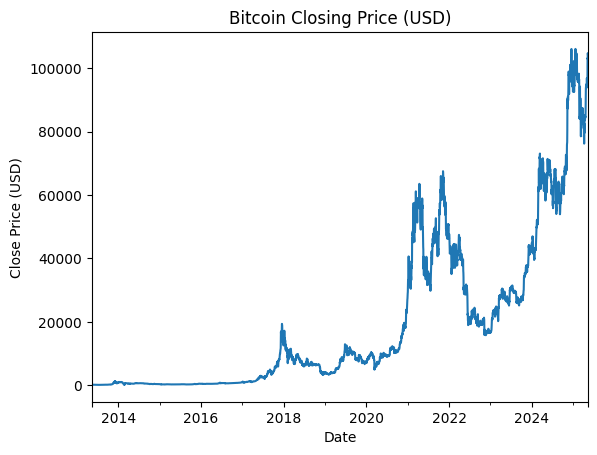

In [11]:
df['close_usd'].plot(title='Bitcoin Closing Price (USD)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.show()

# 4. Test stationarity with ADFuller

In [12]:
result = adfuller(df['close_usd'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critical Value ({}): {:.3f}'.format(key, value))

ADF Statistic: 0.335171
p-value: 0.978902
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


# 5. Fit SARIMAX (as ARIMA) model

In [13]:
d_order = 1  # differencing
p = 1        # AR term
q = 1        # MA term
model = SARIMAX(
    df['close_usd'],
    order=(p, d_order, q),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

print(results.summary())


                               SARIMAX Results                                
Dep. Variable:              close_usd   No. Observations:                 4383
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -36337.256
Date:                Wed, 14 May 2025   AIC                          72680.512
Time:                        00:47:06   BIC                          72699.667
Sample:                    05-12-2013   HQIC                         72687.271
                         - 05-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2646      0.117     -2.257      0.024      -0.494      -0.035
ma.L1          0.2052      0.118      1.733      0.083      -0.027       0.437
sigma2      9.412e+05   7025.357    133.978      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# 6. Forecast future prices

In [14]:
forecast_steps = 30  # next 30 days
start_date = df.index.max() + pd.Timedelta(days=1)
date_index = pd.date_range(start=start_date, periods=forecast_steps, freq='D')

forecast = results.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame(alpha=0.05)
forecast_df.index = date_index

# 7. Plot actual and forecast

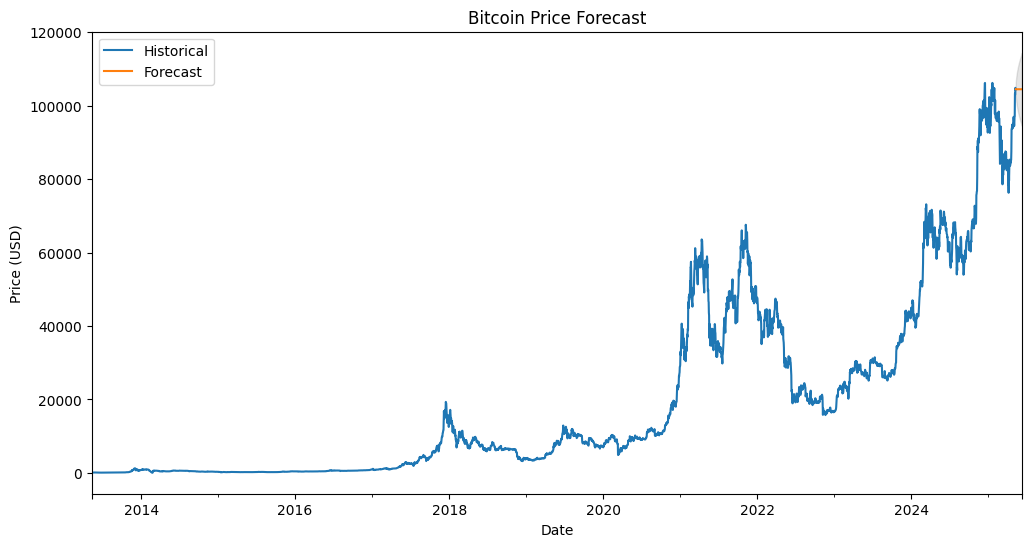

In [15]:
af = df['close_usd'].plot(label='Historical', figsize=(12, 6))
forecast_df['mean'].plot(ax=af, label='Forecast')
af.fill_between(
    forecast_df.index,
    forecast_df['mean_ci_lower'],
    forecast_df['mean_ci_upper'],
    color='k', alpha=0.1
)
plt.title('Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# 7b. Zoomed view of the forecasted period

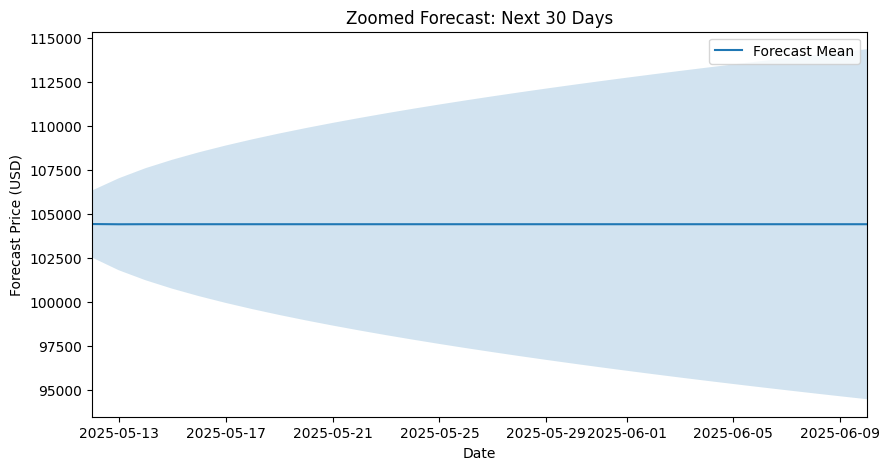

close_usd            mean      mean_se  mean_ci_lower  mean_ci_upper
2025-05-12  104440.415039   970.177302  102538.902469  106341.927609
2025-05-13  104426.813080  1331.959971  101816.219507  107037.406653
2025-05-14  104430.411508  1623.273185  101248.854528  107611.968487
2025-05-15  104429.459536  1867.740637  100768.755155  108090.163917
2025-05-16  104429.711382  2084.193977  100344.766250  108514.656514
2025-05-17  104429.644755  2280.077311   99960.775345  108898.514166
2025-05-18  104429.662382  2460.442741   99607.283223  109252.041540
2025-05-19  104429.657719  2628.453525   99277.983475  109581.331962
2025-05-20  104429.658952  2786.353717   98968.506020  109890.811885
2025-05-21  104429.658626  2935.773081   98675.649121  110183.668131
2025-05-22  104429.658712  3077.947499   98396.992468  110462.324957
2025-05-23  104429.658689  3213.838492   98130.650993  110728.666386
2025-05-24  104429.658695  3344.212156   97875.123313  110984.194078
2025-05-25  104429.658694  3469.69

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast Mean')
plt.fill_between(
    forecast_df.index,
    forecast_df['mean_ci_lower'],
    forecast_df['mean_ci_upper'],
    alpha=0.2
)
plt.title('Zoomed Forecast: Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Forecast Price (USD)')
plt.xlim(forecast_df.index.min(), forecast_df.index.max())
plt.legend()
plt.show()
print(forecast_df)

# 8. Push forecast table to PostgreSQL for Sisense

In [19]:
forecast_sql = forecast_df.reset_index()
forecast_sql.rename(columns={'index': 'date', 'mean': 'forecast_mean',
                             'mean_ci_lower': 'ci_lower', 'mean_ci_upper': 'ci_upper'}, inplace=True)
# Write to a new table (or replace if exists)
forecast_sql.to_sql(
    'bitcoin_price_forecast',
    engine,
    if_exists='replace',
    index=False,
    dtype={
        'date': sqlalchemy.types.Date(),
        'forecast_mean': sqlalchemy.types.Float(),
        'ci_lower': sqlalchemy.types.Float(),
        'ci_upper': sqlalchemy.types.Float(),
        'mean_se': sqlalchemy.types.Float(),
        'mean_ci_lower': sqlalchemy.types.Float(),
        'mean_ci_upper': sqlalchemy.types.Float()
    }
)
print('Forecast table written to Postgres: bitcoin_price_forecast')

Forecast table written to Postgres: bitcoin_price_forecast
